In [17]:
import numpy as np 
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from head import AmplitudePhaseDistance
from geomstats.geometry.functions import SRVF
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from matplotlib import cm
import matplotlib
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.linear_model import LinearRegression
from matplotlib.colors import Normalize
from sklearn.preprocessing import MinMaxScaler
plt.rcParams.update({
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15,
                     "savefig.dpi": 400,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )

In [18]:
def load_spectra(path):
    for itr in range(7):
        spectra_iteration = pd.read_excel(path + str(itr) + '.xlsx').values
        wavelength = spectra_iteration[:,0]
        if itr == 0:
            spectra_all = spectra_iteration[:,1:]
        else:
            spectra_all = np.hstack((spectra_all, spectra_iteration[:,1:]))
    return spectra_all, wavelength 

def load_x(path):
    all_x = np.load(path + str(7) + '/train_x.npy') #All x_values from 0th iteration to iteration-1 
    return all_x

In [19]:
AP_ROD_y, wavelength = load_spectra('../data_AP_ROD/')
AP_SPHERE_y, _ = load_spectra('../data_AP_SPHERE/')
SRVF_ROD_y, _ = load_spectra('../data_SRVF_ROD/')
SRVF_SPHERE_y, _ = load_spectra('../data_SRVF_SPHERE/')
euclidean_ROD_y, _ = load_spectra('../data_euclidean_ROD/')
euclidean_SPHERE_y, _ = load_spectra('../data_euclidean_SPHERE/')
peakwv_ROD_y, _ = load_spectra('../data_peakwv_ROD/')
peakwv_SPHERE_y, _ = load_spectra('../data_peakwv_SPHERE/')

In [20]:
AP_ROD_x = load_x('../data_AP_ROD/')
AP_SPHERE_x = load_x('../data_AP_SPHERE/')
SRVF_ROD_x = load_x('../data_SRVF_ROD/')
SRVF_SPHERE_x = load_x('../data_SRVF_SPHERE/')
euclidean_ROD_x = load_x('../data_euclidean_ROD/')
euclidean_SPHERE_x = load_x('../data_euclidean_SPHERE/')
peakwv_ROD_x = load_x('../data_peakwv_ROD/')
peakwv_SPHERE_x = load_x('../data_peakwv_SPHERE/')

In [21]:
target = pd.read_excel('Target_Rod.xlsx')
target = np.asarray(target)
xt = target[:,0]
rod_target = target[:,1]
target = pd.read_excel('Target_Sphere.xlsx')
target = np.asarray(target)
xt = target[:,0]
sphere_target = target[:,1]

In [22]:
#spectra
SPHERES_y = np.hstack((peakwv_SPHERE_y, euclidean_SPHERE_y, SRVF_SPHERE_y, AP_SPHERE_y))
RODS_y = np.hstack((peakwv_ROD_y, euclidean_ROD_y, SRVF_ROD_y, AP_ROD_y))
all_y = np.hstack((SPHERES_y, RODS_y))

In [23]:
all_y.shape

(101, 224)

In [24]:
#concentrations
SPHERES_x = np.vstack((peakwv_SPHERE_x, euclidean_SPHERE_x, SRVF_SPHERE_x, AP_SPHERE_x))
RODS_x = np.vstack((peakwv_ROD_x, euclidean_ROD_x, SRVF_ROD_x, AP_ROD_x))
all_x = np.vstack((SPHERES_x, RODS_x))

In [25]:
all_x.shape

(224, 2)

In [26]:
def Euclidean(f1,f2):
    d = distance.euclidean(f1,f2)    
    return -d

def peakwv_sphere(f1,f2):
    d = (np.abs((np.argmax(f1) - np.argmax(f2))/100) + np.abs(np.max(f1) - np.max(f2)))
    return -d

def AP(f1,f2):
    da, dp = AmplitudePhaseDistance(f1,f2,xt)
    return -(da + dp)

def SRVF_metric(f1,f2):
    target = pd.read_excel('Target_Rod.xlsx')
    target = np.asarray(target)
    xt = target[:,0]
    M = SRVF(xt.reshape(-1,1).flatten())
    yi = np.asarray(f1).reshape(-1,1).flatten()
    yt = np.asarray(f2).reshape(-1,1).flatten()
    score = -M.metric.dist(yt,yi)
    return score
    

In [27]:
def calculate_distance(metric, concentrations, spectra, target):
    dist = []
    spectra = spectra.T
    for i in range(spectra.shape[0]):
        d = metric(target, spectra[i,:])
        dist.append(d)
    dist = np.array(dist).reshape(-1,1)
    array = np.hstack((dist, concentrations, spectra))
    return array 

In [51]:
def heat_map(x, y, Target):
    array = calculate_distance(Euclidean, x, y, Target)
    dist = array[:,0].reshape(-1,1)
    scaler = MinMaxScaler()
    dist = scaler.fit(dist).transform(dist)
    #kernel = DotProduct() + WhiteKernel()
    #kernel = 1.0 * Matern(length_scale=2.0, nu=2.5)
    gpr = GaussianProcessRegressor().fit(x, dist)
    print(gpr.score(x, dist))
    grid = np.zeros((50,50))
    for rows in range(grid.shape[0]):
        for columns in range(grid.shape[1]):
            dist_pred = gpr.predict(np.array([rows/grid.shape[0],columns/grid.shape[1]]).reshape(1,-1))[0][0]
            grid[-rows, columns] = dist_pred
    #plt.imshow(grid, extent=[0, 1, 0, 1])
    return grid, array

0.9455477044821765


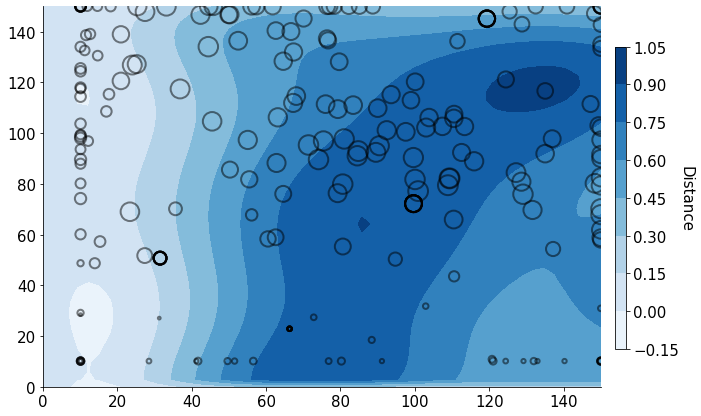

In [52]:
grid, array = heat_map(all_x,all_y, rod_target)
x = np.linspace(0,150,50)
y = np.linspace(0,150,50)
dist = array[:,0].reshape(-1,1)
train_obj = dist
norm = matplotlib.colors.Normalize(vmin= np.min(train_obj), vmax = np.max(train_obj))
fig, ax = plt.subplots(figsize=(10,7))
im = ax.contourf(x,y,grid, cmap=cm.Blues)
for i in range(all_x.shape[0]):
    ax.scatter(all_x[i,0]*140+10, all_x[i,1]*140+10, marker = 'o',fc='none', lw=2.0, alpha=0.5, s = 400*norm(train_obj[i]), color = 'k') #color = cmap(norm(train_obj[i])))
cax = plt.axes([0.92, 0.2, 0.015, 0.6])        
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Distance', rotation=270)
cbar.ax.get_yaxis().labelpad = 15

0.9038507039344706


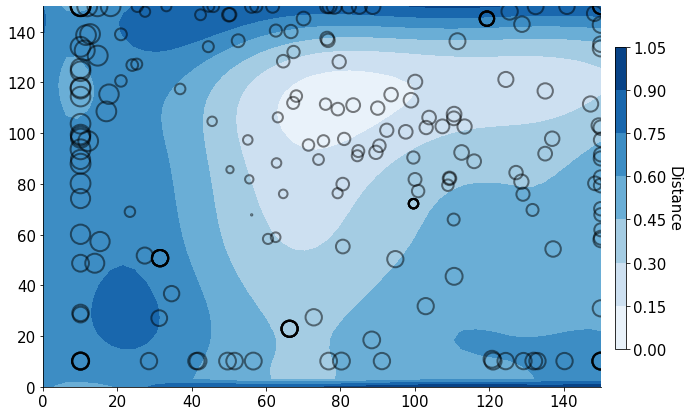

In [53]:
grid, array = heat_map(all_x,all_y, sphere_target)
x = np.linspace(0,150,50)
y = np.linspace(0,150,50)
dist = array[:,0].reshape(-1,1)
train_obj = dist
norm = matplotlib.colors.Normalize(vmin= np.min(train_obj), vmax = np.max(train_obj))
fig, ax = plt.subplots(figsize=(10,7))
im = ax.contourf(x,y,grid, cmap=cm.Blues)
for i in range(all_x.shape[0]):
    ax.scatter(all_x[i,0]*140+10, all_x[i,1]*140+10, marker = 'o',fc='none', lw=2.0, alpha=0.5, s = 400*norm(train_obj[i]), color = 'k') #color = cmap(norm(train_obj[i])))
cax = plt.axes([0.92, 0.2, 0.015, 0.6])        
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Distance', rotation=270)
cbar.ax.get_yaxis().labelpad = 15